# Aircraft Engine RUL Prediction

In [2]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler #to normalize data
import os
os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks

In [3]:
# based on data wrangling python notebook
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index    
    return df_train, df_test, y_true

In [4]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [6]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

## Model

### Data Preprocessing

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [7]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])


LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [8]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [9]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [15]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df], ignore_index=True)    
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)


Let's define look back period and mask_value

In [11]:
sequence_length = 50
mask_value = 0


Let's prepare data using above functions.

In [12]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [13]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [16]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [17]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

### LSTM Model

In [18]:
nb_features = x_train.shape[2]
nb_out = 1

In [19]:
nb_features

15

In [20]:
history = History()
model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-11 12:28:49.207492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-11 12:28:49.207982: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           46400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 126,901
Trainable params: 126,901
Non-trainable params: 0
__________________________________________________

In [21]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

2022-10-11 12:29:15.740835: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-11 12:29:15.743404: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2022-10-11 12:29:16.525251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-11 12:29:16.709922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-11 12:29:16.855788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-11 12:29:17.094279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-11 12:29:17.345235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


443/443 [==============================] - ETA: 0s - loss: 5885.1870 - mse: 5885.1870

2022-10-11 12:29:38.087043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-11 12:29:38.143932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-11 12:29:38.251751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


443/443 [==============================] - 24s 49ms/step - loss: 5885.1870 - mse: 5885.1870 - val_loss: 6008.0850 - val_mse: 6008.0850
Epoch 2/100
443/443 [==============================] - 20s 46ms/step - loss: 2750.1648 - mse: 2750.1648 - val_loss: 3463.6479 - val_mse: 3463.6479
Epoch 3/100
443/443 [==============================] - 20s 46ms/step - loss: 1880.7008 - mse: 1880.7008 - val_loss: 2350.3630 - val_mse: 2350.3630
Epoch 4/100
443/443 [==============================] - 20s 46ms/step - loss: 1617.1962 - mse: 1617.1962 - val_loss: 2118.3369 - val_mse: 2118.3369
Epoch 5/100
443/443 [==============================] - 20s 46ms/step - loss: 1882.7006 - mse: 1882.7006 - val_loss: 2772.9270 - val_mse: 2772.9270
Epoch 6/100
443/443 [==============================] - 20s 46ms/step - loss: 1874.8937 - mse: 1874.8937 - val_loss: 3144.8877 - val_mse: 3144.8877
Epoch 7/100
443/443 [==============================] - 20s 46ms/step - loss: 1781.9351 - mse: 1781.9351 - val_loss: 2051.0715 - va

Let's plot the loss

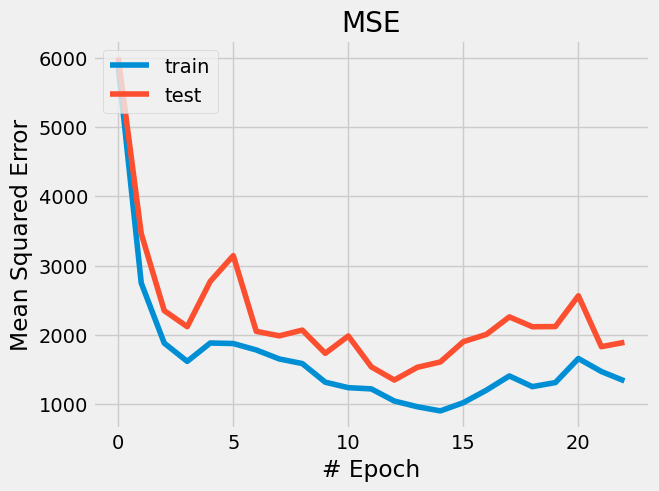

In [24]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results on Train Set

In [25]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

79/79 [==============================] - 2s 26ms/step - loss: 1373.8198 - mse: 1373.8198
MSE: 1373.81982421875


### Results on Test Set

In [26]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))

4/4 - 0s - loss: 1419.6433 - mse: 1419.6433
MSE: 1419.643310546875


2022-10-11 12:43:48.246805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-11 12:43:48.293423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-11 12:43:48.401563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


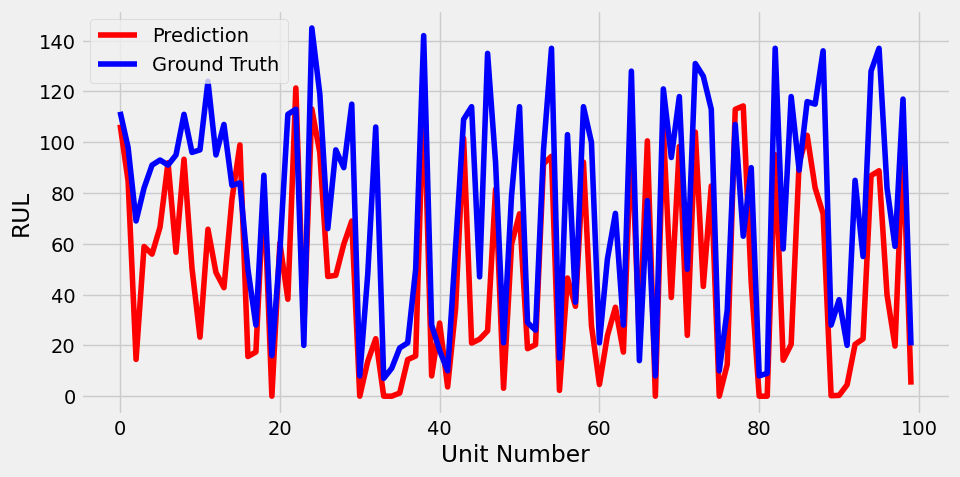

In [27]:
y_pred_test = model.predict(x_test, verbose=0)
plt.figure(figsize=(10,5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()